1. Ensure you have data structured longitudinally i.e. for each person, have the FEV1 and O2 data as time series.
2. Then run the current ‘point in time model’ (FEV1 only) for each FEV1 measurement for a person.
3. Produce a visualisation of the output of the model which shows all time point at once e.g. have time on the x-axis and some display of the uncertain distributions of the latent variables on the y axis. Could be sideways bar charts or box plots or whatever looks best.
4. Then we need to make a longitudinal model which has all data points at once for an individual. The simplest way to do this is to separate out the lung damage and airway blockage variables (as we always intended) and have **one** lung damage variable shared across all time points. This represents the assumption that lung damage is constant at this time scale. Then have separate blockage variables for each time point. Try to get this model running if you can + update your visualisation to include the extra lung damage latent variable.

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../data/")

import O2_FEV1_df
import model_lung_health
import biology as bio

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plotsdir = "../../../../PlotsSmartcare/longitudinal_model/"

In [2]:
O2_FEV1 = O2_FEV1_df.create()



** Loading measurements data **


/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/milestone_model/../data/measurements_data.py:101: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "mydata.csv")



* Dropping unnecessary columns from measurements data *
Columns filtered ['User ID', 'UserName', 'Recording Type', 'Date/Time recorded', 'FEV 1', 'Weight in Kg', 'O2 Saturation', 'Pulse (BPM)', 'Rating', 'Temp (deg C)']
Dropping columns {'Predicted FEV', 'Activity - Steps', 'Calories', 'FEV 10', 'FEV 1 %', 'Sputum sample taken?', 'Activity - Points'}

* Renaming columns *
Renamed columns {'Date/Time recorded': 'Date recorded', 'FEV 1': 'FEV1', 'Weight in Kg': 'Weight (kg)'}

* Applying data sanity checks *

FEV1
Dropping 1 entries with FEV1 = 3.45 for user Kings004

Weight (kg)
Dropping 2 entries with Weight (kg) = 6.0 for user Papworth033
Dropping 1 entries with Weight (kg) = 0.55 for user Kings013
Dropping 1 entries with Weight (kg) = 8.262500000000001 for user Papworth017
Dropping 1 entries with Weight (kg) = 1056.0 for user leeds01730
Dropping 1 entries with Weight (kg) = 20.0 for user Papworth019
Warning - ID PapworthSummer has Weight (28.9375) outside 30-122 kg range
Warning - I

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/tristan.trebaol/Desktop/PhD/Code/phd/src/milestone_model/../data/patient_data.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Height.loc[df.ID == "60"] = tmp * 100



* Dropping unnecessary columns from antibiotics data *
Columns filetered: ['ID', 'Antibiotic Name', 'Route', "Home IV's'", 'Start Date', 'Stop Date']
Columns dropped: {'Hospital', 'Antibiotic ID', 'Study Number'}

** Creating DataFrame for O2 FEV1 analysis **
O2 Saturation has 14011 measurements
FEV1 has 9936 measurements
Merged O2 and FEV1 into 9526 entries (initially 14421, removed 4895 NaN)
Asserting that there's only one measurement per ID per day

Created df_O2_FEV1 with 9526 entries (initially 14421, removed 4895)


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
# Settings
set_age = 33
set_height = 165
set_sex = "Male"
FEV1 = bio.calc_predicted_fev1(set_height, set_age, set_sex)
pred_FEV1 = FEV1["Predicted FEV1"]
pred_FEV1_std = FEV1["std"]

# healthy_FEV1_prior={"type":"uniform"}
healthy_FEV1_prior = {"type": "gaussian", "mu": pred_FEV1, "sigma": pred_FEV1_std}

inference, FEV1, HFEV1, prior_HFEV1, Av, prior_av = model_lung_health.build_healthy(
    healthy_FEV1_prior
)

calculating cpt of shape 59 x 50 x 16 (C x (A x B)) 


/var/folders/zq/v2r6yn111s3gpdf8lzf72xvw0000gn/T/ipykernel_35037/3198543569.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


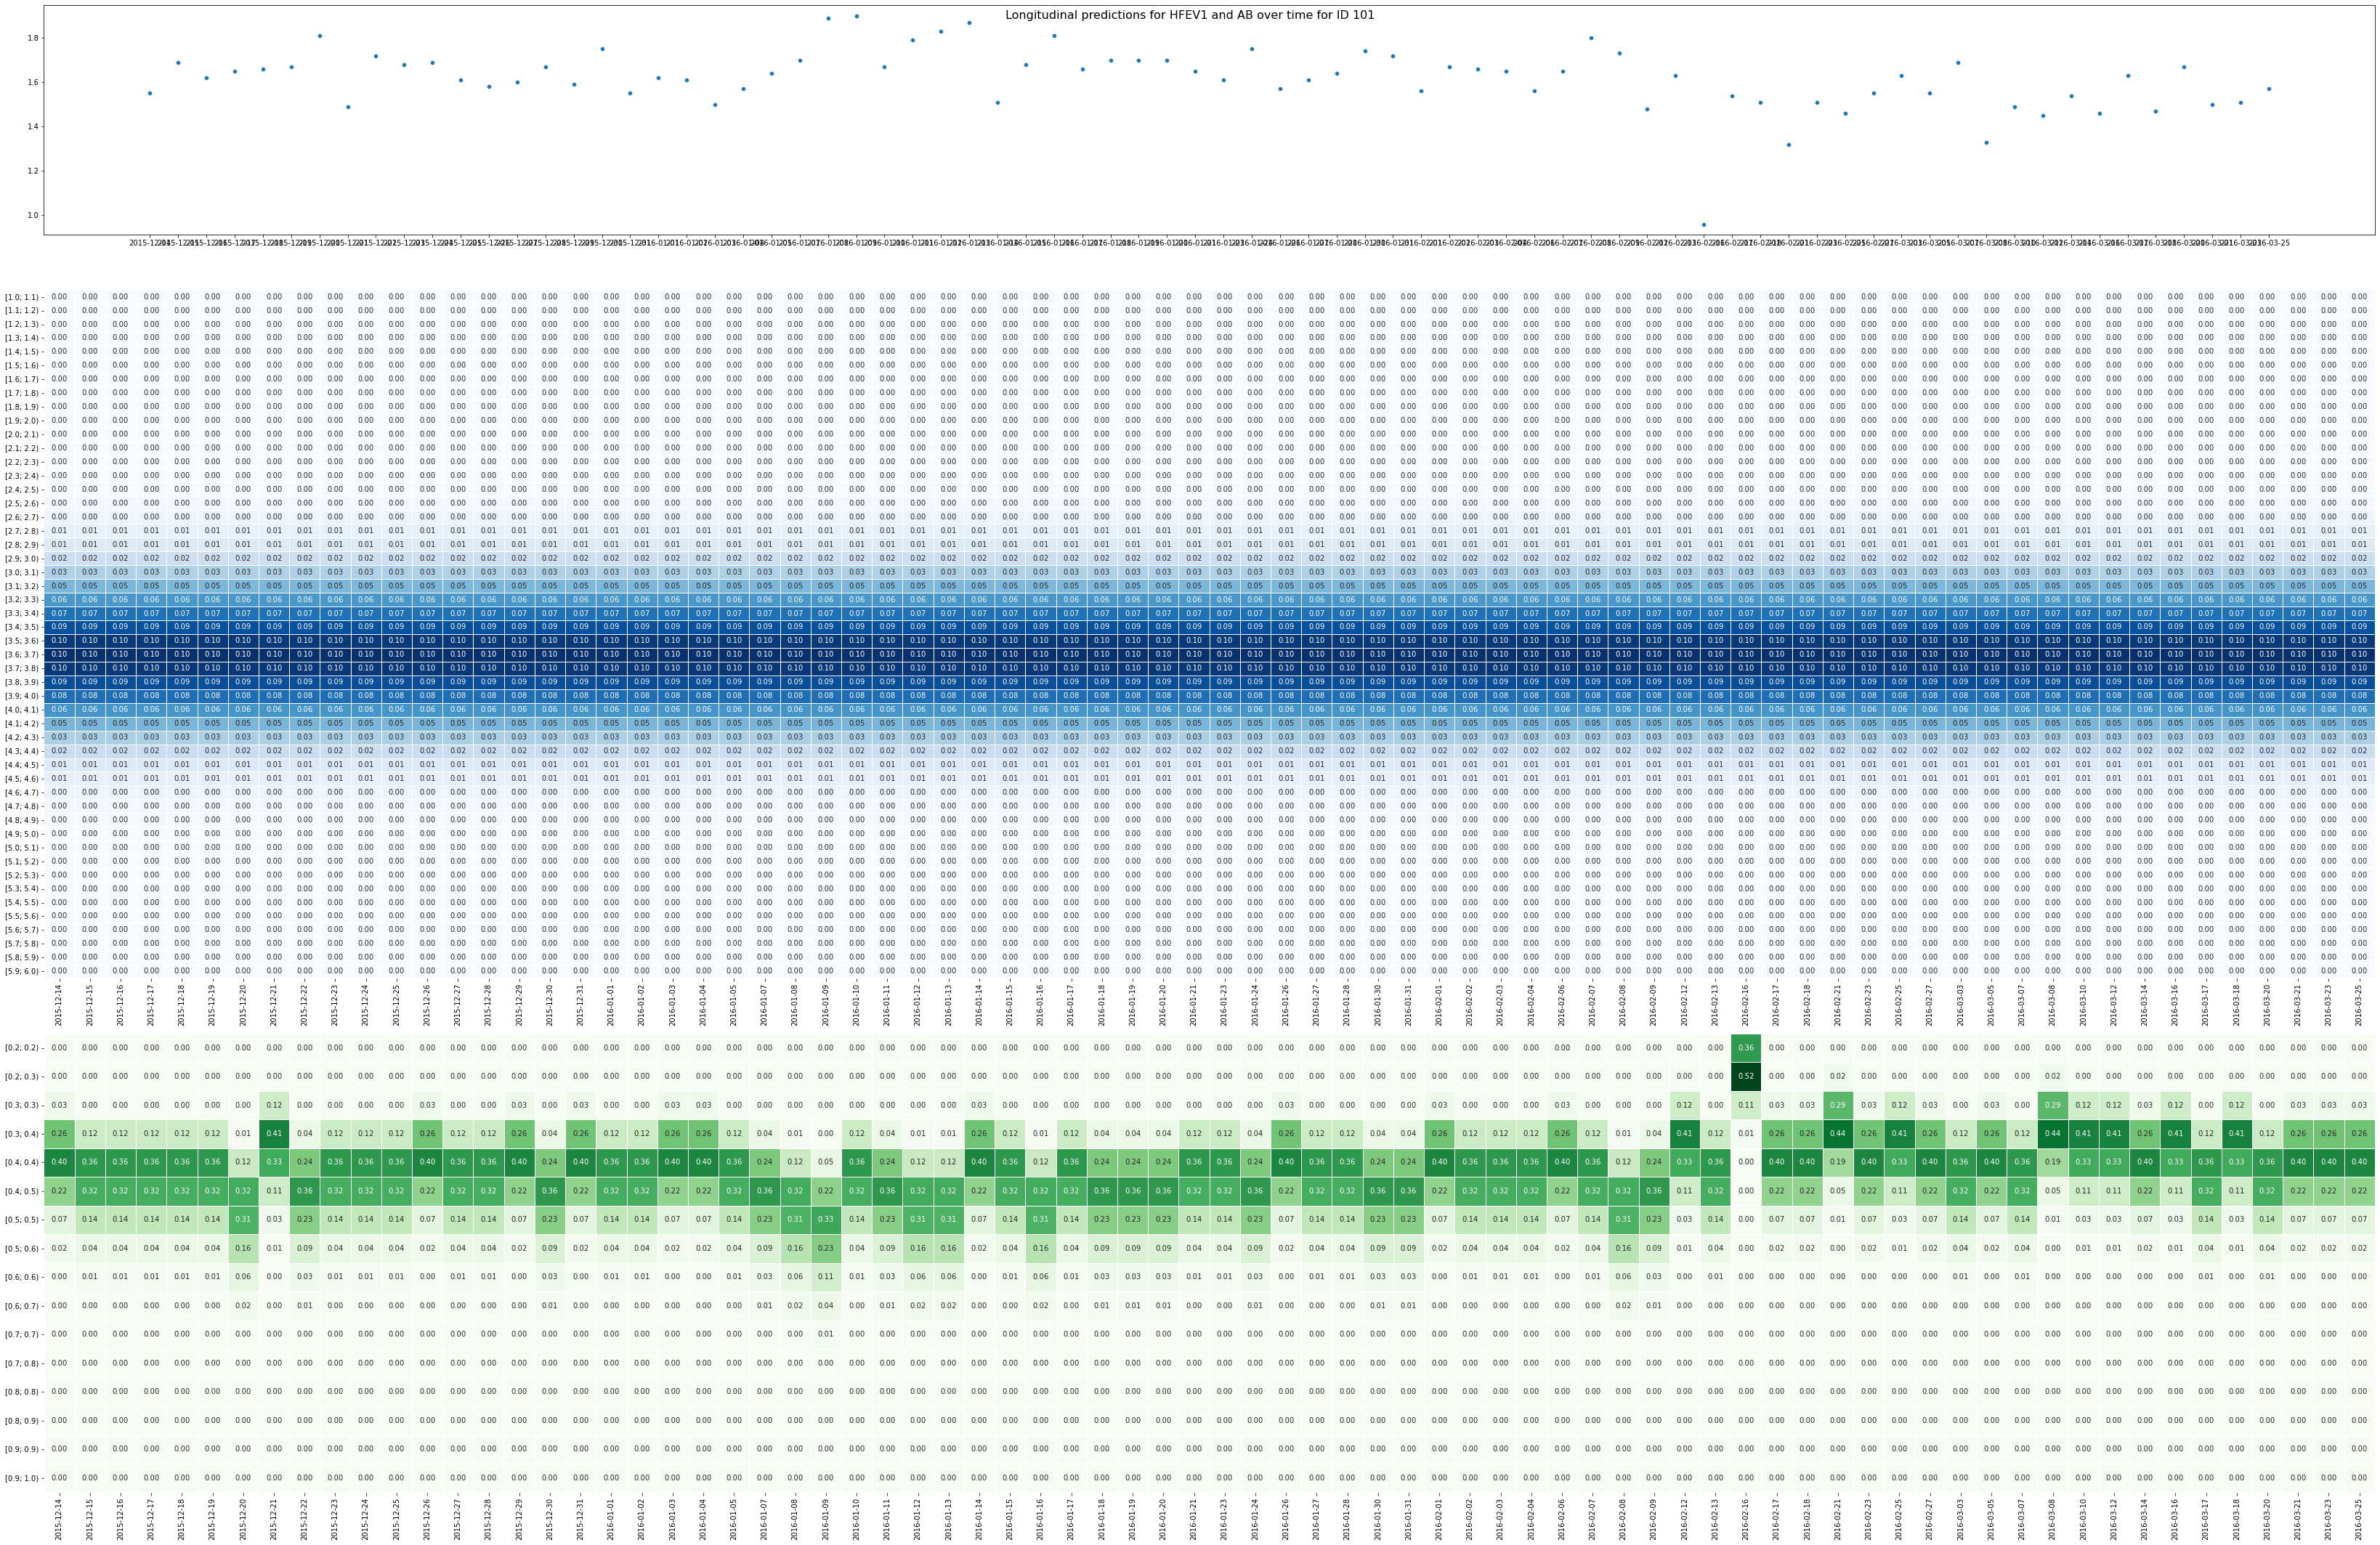

In [28]:
for id in ["101"]:  # O2_FEV1.ID.unique()[0:50]:
    df_for_ID = O2_FEV1[O2_FEV1.ID == id]
    fev1 = df_for_ID.FEV1.values
    days = df_for_ID["Date recorded"].astype(str).values
    days_with_fev1 = [f"{days[i]} ({fev1[i]} L)" for i in range(len(days))]

    # Create empty dataframe of with HFEV1.bins as index name, and days as column names
    hfev1_df = pd.DataFrame(index=HFEV1.bins_str, columns=days)
    av_df = pd.DataFrame(index=Av.bins_str, columns=days)

    for i in range(len(fev1)):
        res_hfev1 = model_lung_health.infer(inference, [HFEV1], [[FEV1, fev1[i]]])
        res_av = model_lung_health.infer(inference, [Av], [[FEV1, fev1[i]]])
        hfev1_df[days[i]] = res_hfev1.values
        av_df[days[i]] = res_av.values

    # Create heatmap using sns with hfev1_df index on x, columns on y, coloured by values
    title = f"Longitudinal predictions for HFEV1 and AB over time for ID {id}"

    fig, axs = plt.subplots(
        3, 1, figsize=(len(fev1) * 0.6, 30), gridspec_kw={"height_ratios": [1, 3, 2]}
    )

    fig.suptitle(title, fontsize=16)
    sns.scatterplot(x=days, y=fev1, ax=axs[0])

    # Add heatmap on bottom plot
    sns.heatmap(
        hfev1_df,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        ax=axs[1],
        cbar=False,
    )

    sns.heatmap(
        av_df,
        cmap="Greens",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        ax=axs[2],
        cbar=False,
    )

    plt.tight_layout()
    plt.savefig(f"{plotsdir}{title}.png")
    plt.close()
    fig.show()